Names:

In [4]:
# your import statements
import context
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd

/Users/rachelwhite/Nextcloud/Teaching/EOSC511_ATSC409/ATSC409_EOSC511/numeric_2024/worksheets/Worksheets_Lab5_2_UG
******************************
context imported. Front of path:
/Users/rachelwhite/Nextcloud/Teaching/EOSC511_ATSC409/ATSC409_EOSC511/numeric_2024
back of path: /Users/rachelwhite/Applications/miniforge3/envs/numeric_2024/lib/python3.12/site-packages
******************************

through /Users/rachelwhite/Nextcloud/Teaching/EOSC511_ATSC409/ATSC409_EOSC511/numeric_2024/worksheets/Worksheets_Lab5_2_UG/context.py


# WorkSheet Instructions ##

Before you begin you should have read and worked through Lab 5.

 I recommend that you do this worksheet in a python
  notebook and share screen.  This method does mean one person will do the typing.  When complete, print or Latex to pdf and upload to CANVAS.

This question will help you think about how to add predators into DaisyWorld, which you will work on for Mini-project 2.

  

For the given set of Daisyworld parameters and initial conditions in pred_worksheet.yaml:

## Question A ###
The code below uses the adaptive timestep Runge-Kutta for default values given in pred_worksheet.yaml. 

Imagine a scenario where a daisy-picking machine picks 5% of all daisies present at each timestep. Add this scenario by using the original Integ54 without any changes, but by changing the relevant value in pred_worksheet.yaml (I recommend you make a new copy of the yaml file, named pred_worksheet2.yaml). Plot the initial values, and these new values on the same graph and compare.  

In [76]:
# functions for worksheet problems

class Integ54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi)
        f[1] = y[1] * (beta_b * bare - user.chi)
        return f

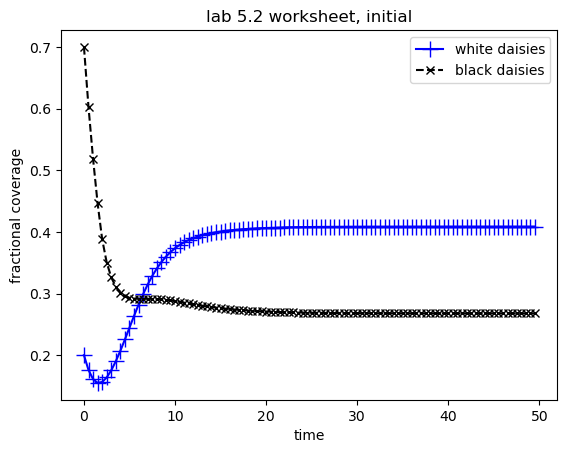

In [77]:
# Solve and plot for adaptive timestep
theSolver = Integ54('pred_worksheet.yaml')
timeVals_ini, yVals_ini, errorList = theSolver.timeloop5fixed()

yvals_ini = pd.DataFrame.from_records(yVals_ini, columns=['white', 'black'])

thefig, theAx = plt.subplots(1, 1)

points, = theAx.plot(timeVals_ini, yvals_ini['white'], '-b+', label='white daisies')
points.set_markersize(12)
theLine1, = theAx.plot(timeVals_ini, yvals_ini['black'], '--kx', label='black daisies')
theAx.set_title('lab 5.2 worksheet, initial')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')


## Question B ###  
Now imagine the daisy-picking machine only likes black daisies, and so it picks 5% of all the black daisies at each timestep. Now you can't do this through the parameters in the current set-up. Create a new version of Integ54 (I suggest you call it something different), and add this daisy-picking to the code directly within derivs5. Compare to the steady state solutions and explain the changes you see. 


## Question C ###  
Now imagine our daisy-picking machine has no interest in sustainable daisy-picking, and so instead of picking a percentage of the available daisies, it always picks 0.02 fractional coverage of black daisies and 0.02 fractional coverage of white daisies every second. Create a new version of Integ54 with this daisy-picking. Compare to the steady state solutions and explain the changes you see, including any differences between changes in black daisies and changes in white daisies


## Question D ###  
Explore what happens if you increase the daisy-picking rate gradually, up to 0.05. Describe the changes you see, and whether they are physical or not.

## Question D ###  
If you haven't already, adapt your code so the daisy fractional coverage cannot go negative (I made changes to the timeloop5fixed function - look for it in numlabs/lab5, and copy into your Integ54(Integrator) class - you can then make changes to it here). Re-run the scenario from Question C, discussing the differences from your previous simulation. 